# importing libraries

In [1]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.ml.linalg import DenseVector
from sklearn.metrics import accuracy_score
import pandas as pd


import pyspark
from pyspark import SparkContext


import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,recall_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier



from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import LinearSVC
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,confusion_matrix

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# ReadingData into PySpark

In [2]:
sc =SparkContext()
sc.addFile("H-1B_Disclosure_Data_FY2019.csv")

In [3]:
sqlContext = SQLContext(sc)
sqlContext
df = sqlContext.read.csv(SparkFiles.get("H-1B_Disclosure_Data_FY2019.csv"), header=True, inferSchema= True)


# distribution

In [4]:
df.groupBy('CASE_STATUS').count().show()


len(df.columns)

+-------------------+------+
|        CASE_STATUS| count|
+-------------------+------+
|          CERTIFIED|597831|
|CERTIFIED-WITHDRAWN| 41218|
|          WITHDRAWN| 19674|
|             DENIED|  5893|
+-------------------+------+



73

In [5]:
#dropping columns that were irrelevant

cols=['CASE_NUMBER','DECISION_DATE','ORIGINAL_CERT_DATE','EMPLOYER_BUSINESS_DBA','EMPLOYER_ADDRESS','EMPLOYER_CITY']
col2=['EMPLOYER_PROVINCE','EMPLOYER_PHONE','EMPLOYER_PHONE_EXT','SECONDARY_ENTITY','SECONDARY_ENTITY_BUSINESS_NAME']
col3=['SECONDARY_ENTITY', 'SECONDARY_ENTITY_BUSINESS_NAME', 'AGENT_REPRESENTING_EMPLOYER', 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE']
col4=['SECONDARY_ENTITY', 'SECONDARY_ENTITY_BUSINESS_NAME', 'AGENT_REPRESENTING_EMPLOYER', 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE']
col5=['VISA_CLASS','EMPLOYER_COUNTRY','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY','PW_SOURCE','PW_SOURCE_OTHER','PW_WAGE_LEVEL','WORKSITE_POSTAL_CODE','WORKSITE_CITY','WAGE_RATE_OF_PAY_TO','SOC_NAME','CASE_SUBMITTED','WORKSITE_POSTAL_CODE','STATUTORY_BASIS','EMPLOYER_POSTAL_CODE','APPX_A_NO_OF_EXEMPT_WORKER_1','APPX_A_NAME_OF_INSTITUTION_1','APPX_A_FIELD_OF_STUDY_1', 'APPX_A_DATE_OF_DEGREE_1', 'APPX_A_NO_OF_EXEMPT_WORKER_2', 'APPX_A_NAME_OF_INSTITUTION_2', 'APPX_A_FIELD_OF_STUDY_2', 'APPX_A_DATE_OF_DEGREE_2', 'APPX_A_NO_OF_EXEMPT_WORKER_3', 'APPX_A_NAME_OF_INSTITUTION_3', 'APPX_A_FIELD_OF_STUDY_3', 'APPX_A_DATE_OF_DEGREE_3', 'APPX_A_NO_OF_EXEMPT_WORKER_4', 'APPX_A_NAME_OF_INSTITUTION_4', 'APPX_A_FIELD_OF_STUDY_4', 'APPX_A_DATE_OF_DEGREE_4', 'APPX_A_NO_OF_EXEMPT_WORKER_5', 'APPX_A_NAME_OF_INSTITUTION_5', 'APPX_A_FIELD_OF_STUDY_5', 'APPX_A_DATE_OF_DEGREE_5','MASTERS_EXEMPTION']

df2=df.drop(*cols)
df2=df2.drop(*col2)
df2=df2.drop(*col3)
df2=df2.drop(*col4)
df2=df2.drop(*col5)

print(df2.printSchema())

root
 |-- CASE_STATUS: string (nullable = true)
 |-- EMPLOYMENT_START_DATE: string (nullable = true)
 |-- EMPLOYMENT_END_DATE: string (nullable = true)
 |-- EMPLOYER_NAME: string (nullable = true)
 |-- EMPLOYER_STATE: string (nullable = true)
 |-- JOB_TITLE: string (nullable = true)
 |-- SOC_CODE: string (nullable = true)
 |-- NAICS_CODE: integer (nullable = true)
 |-- TOTAL_WORKERS: integer (nullable = true)
 |-- NEW_EMPLOYMENT: string (nullable = true)
 |-- CONTINUED_EMPLOYMENT: string (nullable = true)
 |-- CHANGE_PREVIOUS_EMPLOYMENT: integer (nullable = true)
 |-- NEW_CONCURRENT_EMPLOYMENT: integer (nullable = true)
 |-- CHANGE_EMPLOYER: integer (nullable = true)
 |-- AMENDED_PETITION: integer (nullable = true)
 |-- FULL_TIME_POSITION: string (nullable = true)
 |-- PREVAILING_WAGE: string (nullable = true)
 |-- PW_UNIT_OF_PAY: string (nullable = true)
 |-- H1B_DEPENDENT: string (nullable = true)
 |-- WORKSITE_COUNTY: string (nullable = true)
 |-- WORKSITE_STATE: string (nullable = 

In [42]:
pd_df=df2.toPandas()

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


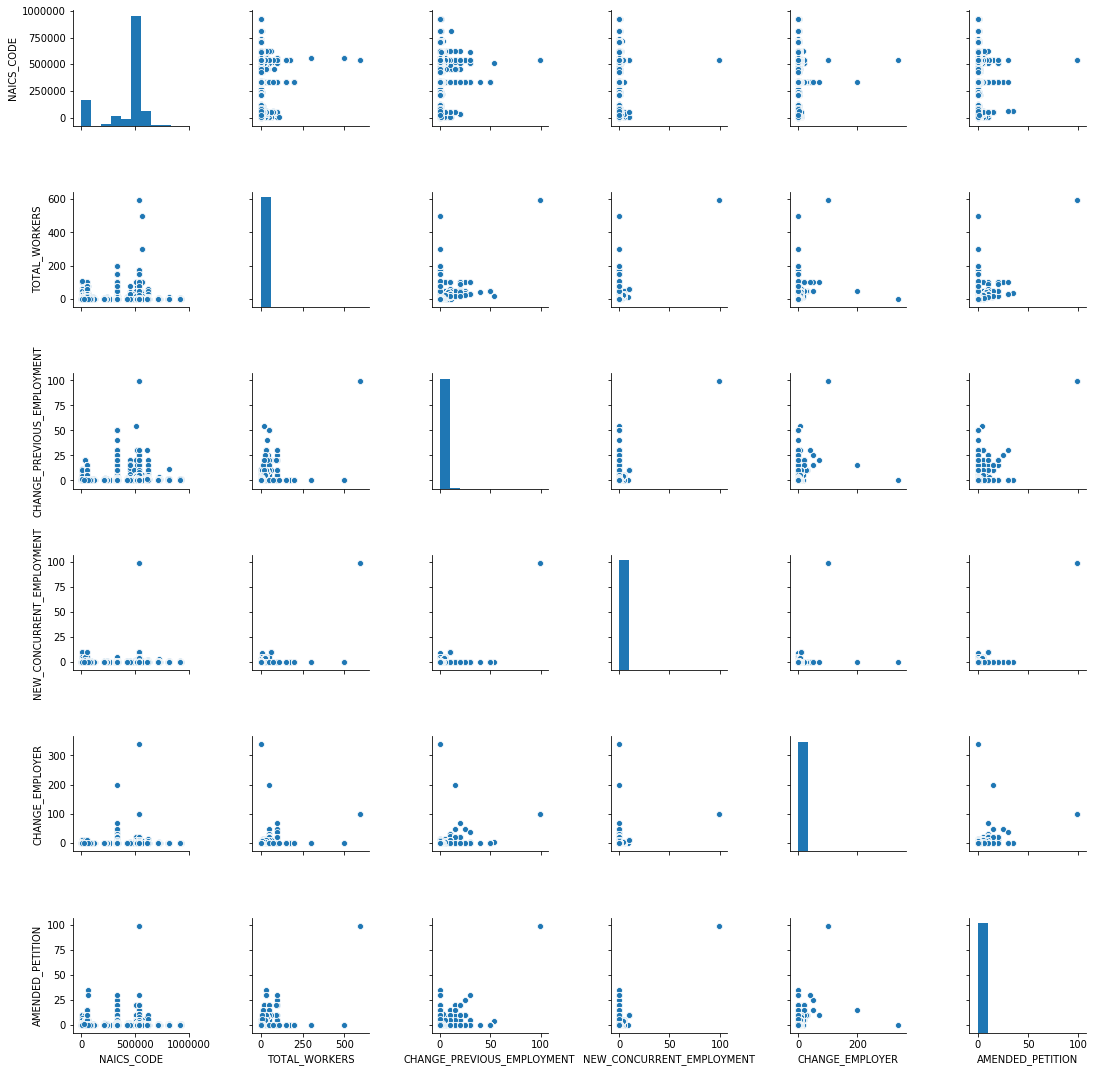

In [44]:
sns.pairplot(pd_df)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = pd_df.corr()
corr

,NAICS_CODE,TOTAL_WORKERS,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION
NAICS_CODE,1.000000,-0.102236,-0.094351,-0.037142,-0.028108,-0.112970
TOTAL_WORKERS,-0.102236,1.000000,0.569345,0.374866,0.504069,0.597364
CHANGE_PREVIOUS_EMPLOYMENT,-0.094351,0.569345,1.000000,0.233980,0.411627,0.517552
NEW_CONCURRENT_EMPLOYMENT,-0.037142,0.374866,0.233980,1.000000,0.300599,0.292767
CHANGE_EMPLOYER,-0.028108,0.504069,0.411627,0.300599,1.000000,0.516583
AMENDED_PETITION,-0.112970,0.597364,0.517552,0.292767,0.516583,1.000000


In [8]:
pd_df.isnull().sum(axis=0)

CASE_STATUS                        0
EMPLOYMENT_START_DATE              0
EMPLOYMENT_END_DATE                0
EMPLOYER_NAME                      1
EMPLOYER_STATE                    41
JOB_TITLE                          1
SOC_CODE                           4
NAICS_CODE                         2
TOTAL_WORKERS                      0
NEW_EMPLOYMENT                     0
CONTINUED_EMPLOYMENT               0
CHANGE_PREVIOUS_EMPLOYMENT         0
NEW_CONCURRENT_EMPLOYMENT          0
CHANGE_EMPLOYER                    0
AMENDED_PETITION                   0
FULL_TIME_POSITION                 0
PREVAILING_WAGE                83662
PW_UNIT_OF_PAY                 83662
H1B_DEPENDENT                  15074
WORKSITE_COUNTY                   46
WORKSITE_STATE                    18
WILLFUL_VIOLATOR               15079
SUPPORT_H1B                   378454
dtype: int64

# Preprocessing all the column,with 0 or N

In [9]:
pd_df['WILLFUL_VIOLATOR']=pd_df['WILLFUL_VIOLATOR'].fillna('N')
pd_df['SUPPORT_H1B']=pd_df['SUPPORT_H1B'].fillna('N')

pd_df['SUPPORT_H1B']=pd_df['SUPPORT_H1B'].replace('NA','N')

pd_df['SUPPORT_H1B']=pd_df['SUPPORT_H1B'].replace('N',0)

pd_df['SUPPORT_H1B']=pd_df['SUPPORT_H1B'].replace('Y',1)

pd_df['WILLFUL_VIOLATOR']=pd_df['WILLFUL_VIOLATOR'].replace('N',0)

pd_df['WILLFUL_VIOLATOR']=pd_df['WILLFUL_VIOLATOR'].replace('Y',1)



pd_df['H1B_DEPENDENT']=pd_df['H1B_DEPENDENT'].fillna('N')

pd_df['H1B_DEPENDENT']=pd_df['H1B_DEPENDENT'].replace('NA','N')

pd_df['H1B_DEPENDENT']=pd_df['H1B_DEPENDENT'].replace('N',0)

pd_df['H1B_DEPENDENT']=pd_df['H1B_DEPENDENT'].replace('Y',1)


pd_df['H1B_DEPENDENT']=pd_df['H1B_DEPENDENT'].fillna('N')

# removing all the Na rows

In [10]:
pd_df=pd_df.dropna()

In [11]:
pd_df.isnull().sum(axis=0)

CASE_STATUS                   0
EMPLOYMENT_START_DATE         0
EMPLOYMENT_END_DATE           0
EMPLOYER_NAME                 0
EMPLOYER_STATE                0
JOB_TITLE                     0
SOC_CODE                      0
NAICS_CODE                    0
TOTAL_WORKERS                 0
NEW_EMPLOYMENT                0
CONTINUED_EMPLOYMENT          0
CHANGE_PREVIOUS_EMPLOYMENT    0
NEW_CONCURRENT_EMPLOYMENT     0
CHANGE_EMPLOYER               0
AMENDED_PETITION              0
FULL_TIME_POSITION            0
PREVAILING_WAGE               0
PW_UNIT_OF_PAY                0
H1B_DEPENDENT                 0
WORKSITE_COUNTY               0
WORKSITE_STATE                0
WILLFUL_VIOLATOR              0
SUPPORT_H1B                   0
dtype: int64

In [12]:
pd_df

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_CODE,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,...,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,H1B_DEPENDENT,WORKSITE_COUNTY,WORKSITE_STATE,WILLFUL_VIOLATOR,SUPPORT_H1B
1,DENIED,11/27/18,11/26/21,UNIVERSITY OF TEXAS AT DALLAS,TX,PROGRAM SPECIALIST,19-1042,611310.0,1,1,...,0,0,Y,"$48,630.00",Year,0,TX,TX,0,0
2,DENIED,11/28/18,11/27/21,UNIVERSITY OF TEXAS AT DALLAS,TX,ASSISTANT PROFESSOR,25-1011,611310.0,1,1,...,0,0,Y,"$79,287.00",Year,0,Dallas,TX,0,0
3,DENIED,1/1/19,1/1/22,BILLY R. WINGARD,NC,HOME HEALTH & PERSONAL CARE AIDE,39-9021,814110.0,1,1,...,0,0,Y,$7.95,Hour,0,Craven,NC,0,0
4,CERTIFIED,4/1/19,4/1/22,"COATES,BRIGHT & BAY LLC",FL,CARE GIVER-LIVE IN- MANAGER,31-9099,621610.0,1,1,...,0,0,Y,$8.46,Hour,1,florida,FL,0,0
5,DENIED,4/8/19,4/7/21,BOWLING GREEN CHRISTIAN ACADEMY,KY,EARLY EDUCATION CLASSROOM ASSISTANT,25-2011,611110.0,1,1,...,0,0,Y,$7.25,Hour,0,19,KY,0,0
6,DENIED,1/1/20,12/31/22,GREEN MEADOW SCHOOL,MP,"TEACHER, ELEMENTARY/SECONDARY",25-3099,61111.0,1,0,...,0,0,Y,$9.28,Hour,0,SAIPAN,MP,0,0
7,CERTIFIED,1/1/20,12/31/22,GREEN MEADOW SCHOOL,MP,"TEACHER, ELEMENTARY/SECONDARY",25-3099,61111.0,1,0,...,0,0,Y,$9.28,Hour,0,SAIPAN,MP,0,0
8,DENIED,12/12/18,12/12/21,NAIL PASSION LLC,FL,"CUSTOMER SERVICE, ALL TASKS & DUTIES OF A NAIL...",39-5092,812113.0,10,10,...,0,0,Y,$8.75,Hour,0,BROWARD,FL,0,0
9,DENIED,7/1/19,6/30/22,OUTBOARD SERVICE COMPANY,MN,SPECIALTY TECHNICIAN,49-3023,441222.0,1,1,...,0,0,Y,$9.86,Hour,0,Cass,MN,0,0
10,CERTIFIED,4/15/19,5/30/19,WARREN COUNTY BOARD OF EDUCATION,KY,EMERGENCY SUBSTITUTE TEACHER,25-3098,611110.0,1,1,...,0,0,N,$9.53,Hour,0,Warren,KY,0,0


In [13]:
corr_df=pd_df[['CASE_STATUS','EMPLOYER_NAME','JOB_TITLE','SOC_CODE','TOTAL_WORKERS','PREVAILING_WAGE']]

corr=corr_df.apply(lambda x: x.factorize()[0]).corr()
corr

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,SOC_CODE,TOTAL_WORKERS,PREVAILING_WAGE
CASE_STATUS,1.000000,0.004261,0.001449,0.000685,-0.024385,-0.007880
EMPLOYER_NAME,0.004261,1.000000,0.214273,-0.036086,-0.043899,0.158018
JOB_TITLE,0.001449,0.214273,1.000000,0.019271,-0.009348,0.252249
SOC_CODE,0.000685,-0.036086,0.019271,1.000000,-0.002775,0.222712
TOTAL_WORKERS,-0.024385,-0.043899,-0.009348,-0.002775,1.000000,0.038185
PREVAILING_WAGE,-0.007880,0.158018,0.252249,0.222712,0.038185,1.000000


# corelation between columns

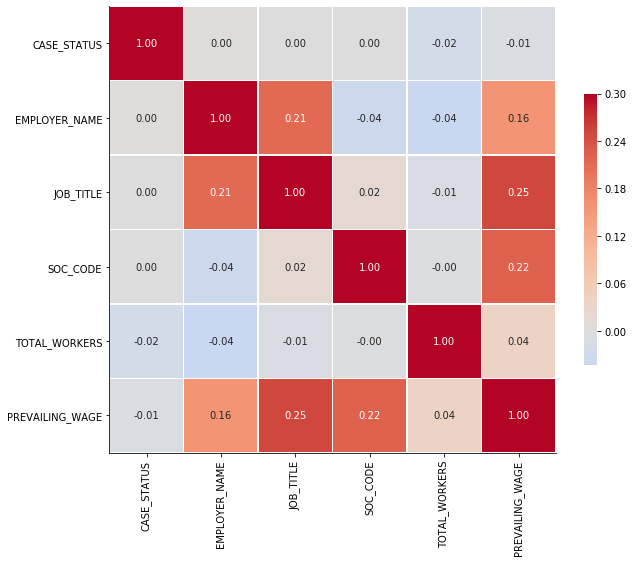

In [14]:
g = sns.heatmap(corr,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(10,10)
plt.show()

In [15]:
#  pd_df.to_csv(r'processed2019_latest.csv')

# calculating total wage from prevailing wage and unit of pay

In [16]:
data_preprocess=pd_df[['PREVAILING_WAGE','PW_UNIT_OF_PAY']]

In [17]:
data_preprocess.PREVAILING_WAGE=data_preprocess.PREVAILING_WAGE.apply(lambda x: x.replace('$',''))
data_preprocess.PREVAILING_WAGE=data_preprocess.PREVAILING_WAGE.apply(lambda x: x.replace(',',''))

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
set(data_preprocess.PW_UNIT_OF_PAY)

{'Bi-Weekly', 'Hour', 'Month', 'Week', 'Year'}

In [19]:
z=[]
for index,row in data_preprocess.iterrows():
    if row.PW_UNIT_OF_PAY=='Year':
        z.append(1)
    elif row.PW_UNIT_OF_PAY=='Hour':
        z.append(1920)
    elif row.PW_UNIT_OF_PAY=='Month':
        z.append(12)
    elif row.PW_UNIT_OF_PAY=='Week':
        z.append(48)
    elif row.PW_UNIT_OF_PAY=='Bi-Weekly':
        z.append(96)
    else:
        z.append(0)


In [20]:
data_preprocess['multiplier']=z

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
data_preprocess['PREVAILING_WAGE_int']=pd.to_numeric(data_preprocess.PREVAILING_WAGE)
data_preprocess['new_wage_in_dollar_per_year']=(data_preprocess.PREVAILING_WAGE_int)*data_preprocess.multiplier

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
pd_df['TOTAL_WAGE']=data_preprocess.new_wage_in_dollar_per_year

In [23]:
# pd_df=pd_df.drop(['PREVAILING_WAGE','PW_UNIT_OF_PAY'],axis=1)
pd_df



,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_CODE,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,...,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,H1B_DEPENDENT,WORKSITE_COUNTY,WORKSITE_STATE,WILLFUL_VIOLATOR,SUPPORT_H1B,TOTAL_WAGE
1,DENIED,11/27/18,11/26/21,UNIVERSITY OF TEXAS AT DALLAS,TX,PROGRAM SPECIALIST,19-1042,611310.0,1,1,...,0,Y,"$48,630.00",Year,0,TX,TX,0,0,48630.0
2,DENIED,11/28/18,11/27/21,UNIVERSITY OF TEXAS AT DALLAS,TX,ASSISTANT PROFESSOR,25-1011,611310.0,1,1,...,0,Y,"$79,287.00",Year,0,Dallas,TX,0,0,79287.0
3,DENIED,1/1/19,1/1/22,BILLY R. WINGARD,NC,HOME HEALTH & PERSONAL CARE AIDE,39-9021,814110.0,1,1,...,0,Y,$7.95,Hour,0,Craven,NC,0,0,15264.0
4,CERTIFIED,4/1/19,4/1/22,"COATES,BRIGHT & BAY LLC",FL,CARE GIVER-LIVE IN- MANAGER,31-9099,621610.0,1,1,...,0,Y,$8.46,Hour,1,florida,FL,0,0,16243.2
5,DENIED,4/8/19,4/7/21,BOWLING GREEN CHRISTIAN ACADEMY,KY,EARLY EDUCATION CLASSROOM ASSISTANT,25-2011,611110.0,1,1,...,0,Y,$7.25,Hour,0,19,KY,0,0,13920.0
6,DENIED,1/1/20,12/31/22,GREEN MEADOW SCHOOL,MP,"TEACHER, ELEMENTARY/SECONDARY",25-3099,61111.0,1,0,...,0,Y,$9.28,Hour,0,SAIPAN,MP,0,0,17817.6
7,CERTIFIED,1/1/20,12/31/22,GREEN MEADOW SCHOOL,MP,"TEACHER, ELEMENTARY/SECONDARY",25-3099,61111.0,1,0,...,0,Y,$9.28,Hour,0,SAIPAN,MP,0,0,17817.6
8,DENIED,12/12/18,12/12/21,NAIL PASSION LLC,FL,"CUSTOMER SERVICE, ALL TASKS & DUTIES OF A NAIL...",39-5092,812113.0,10,10,...,0,Y,$8.75,Hour,0,BROWARD,FL,0,0,16800.0
9,DENIED,7/1/19,6/30/22,OUTBOARD SERVICE COMPANY,MN,SPECIALTY TECHNICIAN,49-3023,441222.0,1,1,...,0,Y,$9.86,Hour,0,Cass,MN,0,0,18931.2
10,CERTIFIED,4/15/19,5/30/19,WARREN COUNTY BOARD OF EDUCATION,KY,EMERGENCY SUBSTITUTE TEACHER,25-3098,611110.0,1,1,...,0,N,$9.53,Hour,0,Warren,KY,0,0,18297.6


In [24]:
pd_df.columns

Index(['CASE_STATUS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_STATE', 'JOB_TITLE', 'SOC_CODE',
       'NAICS_CODE', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT',
       'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT',
       'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'FULL_TIME_POSITION',
       'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'H1B_DEPENDENT', 'WORKSITE_COUNTY',
       'WORKSITE_STATE', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B', 'TOTAL_WAGE'],
      dtype='object')

# removing Withdrawn records

In [25]:
pd_df2 = pd_df.drop(pd_df[(pd_df.CASE_STATUS =='CERTIFIED-WITHDRAWN')].index)
pd_df2 = pd_df2.drop(pd_df2[(pd_df2.CASE_STATUS =='WITHDRAWN')].index)

set(pd_df2.CASE_STATUS)

{'CERTIFIED', 'DENIED'}

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
x=pd_df2
for i in x:
    x[i]=le.fit_transform(x[i])

In [27]:
set(x.CASE_STATUS)

{0, 1}

In [47]:
column_names=x.columns

In [48]:
column_names

for i in len(column_names):
    for j in len(column_names):
        sn

Index(['CASE_STATUS', 'EMPLOYER_NAME', 'EMPLOYER_STATE', 'SOC_CODE',
       'NAICS_CODE', 'TOTAL_WORKERS', 'FULL_TIME_POSITION', 'H1B_DEPENDENT',
       'WILLFUL_VIOLATOR', 'TOTAL_WAGE'],
      dtype='object')

In [28]:
x

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_CODE,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,...,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,H1B_DEPENDENT,WORKSITE_COUNTY,WORKSITE_STATE,WILLFUL_VIOLATOR,SUPPORT_H1B,TOTAL_WAGE
1,1,121,330,59686,48,55235,183,1792,1,1,...,0,1,13688,4,0,4821,47,0,0,3595
2,1,123,334,59686,48,5346,240,1792,1,1,...,0,1,20405,4,0,1266,47,0,0,10563
3,1,0,3,7603,30,32408,420,1932,1,1,...,0,1,18545,1,0,1117,30,0,0,4
4,0,314,768,12607,9,13397,398,1827,1,1,...,0,1,20579,1,1,5441,9,0,0,8
5,1,342,865,8589,19,24249,278,1790,1,1,...,0,1,18544,1,0,40,18,0,0,2
6,1,1,479,24238,27,92937,294,689,1,0,...,0,1,22446,1,0,4074,27,0,0,21
7,0,1,479,24238,27,92937,294,689,1,0,...,0,1,22446,1,0,4074,27,0,0,21
8,1,142,390,38480,9,17898,416,1908,10,2,...,0,1,20580,1,0,455,9,0,0,9
9,1,405,1079,41985,25,84563,490,1440,1,1,...,0,1,22451,1,0,933,25,0,0,39
10,0,320,959,61842,19,25295,293,1790,1,1,...,0,0,22448,1,0,5164,18,0,0,28


In [29]:
y=x.CASE_STATUS

x=x.drop([ 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'WORKSITE_COUNTY',
       'WORKSITE_STATE','EMPLOYMENT_START_DATE','EMPLOYMENT_END_DATE'], axis=1)

x=x.drop([ 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT',
       'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT',
       'CHANGE_EMPLOYER', 'AMENDED_PETITION','JOB_TITLE','SUPPORT_H1B'], axis=1)

In [30]:
from sklearn.utils import resample

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=0)

xTrain_upsampled = resample(xTrain[xTrain.CASE_STATUS==1],
                                      replace=True,  # sample with replacement
                                      n_samples=len(xTrain[xTrain.CASE_STATUS==0]),  # to match minority class
                                      random_state=1)

yTrain_upsampled = resample(yTrain[xTrain.CASE_STATUS==1],
                                      replace=True,  # sample with replacement
                                      n_samples=len(xTrain[xTrain.CASE_STATUS==0]),  # to match minority class
                                      random_state=1)

xTrain_upsampled_1 = pd.concat([xTrain_upsampled, xTrain[xTrain.CASE_STATUS==0]])
yTrain_upsampled_1 = pd.concat([xTrain_upsampled, xTrain[xTrain.CASE_STATUS==0]])

In [31]:
xTrain_upsampled_1.CASE_STATUS.value_counts()


1    382426
0    382426
Name: CASE_STATUS, dtype: int64

In [32]:
x=xTrain_upsampled_1
x2=x.drop(['CASE_STATUS'], axis=1)



yTrain=x.CASE_STATUS


corr = x2.corr()
corr

xTrain=x2
xTest=xTest.drop(['CASE_STATUS'], axis=1)

In [33]:
model=tree.DecisionTreeClassifier(criterion="entropy")


In [34]:
model.fit(xTrain,yTrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
model2 = model.predict(xTest)
print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)


dtreeAccuracy=accuracy_score(yTest, model2)*100



confusion =confusion_matrix(yTest, model2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
auc = roc_auc_score(yTest, model2)
specificity = TN / (TN + FP)



print('*'*45,'Dtree','*'*45)
print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)
print('classification error',(1 - accuracy_score(yTest, model2))*100)
print('sensitivity:',recall_score(yTest, model2))
print('False Positive Rate:',1 - specificity)
print('AUC: %.2f' % auc)
print('Confusion Matrix')
print(confusion_matrix(yTest,model2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    163860
           1       0.08      0.23      0.12      1552

    accuracy                           0.97    165412
   macro avg       0.54      0.60      0.55    165412
weighted avg       0.98      0.97      0.98    165412

The accuracy :-  96.89260754963365
********************************************* Dtree *********************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    163860
           1       0.08      0.23      0.12      1552

    accuracy                           0.97    165412
   macro avg       0.54      0.60      0.55    165412
weighted avg       0.98      0.97      0.98    165412

The accuracy :-  96.89260754963365
classification error 3.107392450366353
sensitivity: 0.22873711340206185
False Positive Rate: 0.024063224704015673
AUC: 0.60
Confusion Matrix
[[159917   3943]
 [  1197    355]]


In [36]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(xTrain, yTrain)
neigh2 = neigh.predict(xTest)
#print(classification_report(yTest, neigh2))
print('The accuracy :- ',accuracy_score(yTest, neigh2)*100)

knnAccuracy=accuracy_score(neigh2, model2)*100


model2=neigh2
confusion =confusion_matrix(yTest, neigh2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
auc = roc_auc_score(yTest, model2)
specificity = TN / (TN + FP)


print('*'*45,'KNN','*'*45)
print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)
print('classification error',(1 - accuracy_score(yTest, model2))*100)
print('sensitivity:',recall_score(yTest, model2))
print('False Positive Rate:',1 - specificity)
print('AUC: %.2f' % auc)
print('Confusion Matrix')
print(confusion_matrix(yTest,model2))

The accuracy :-  96.40594394602569
********************************************* KNN *********************************************
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    163860
           1       0.07      0.23      0.11      1552

    accuracy                           0.96    165412
   macro avg       0.53      0.60      0.54    165412
weighted avg       0.98      0.96      0.97    165412

The accuracy :-  96.40594394602569
classification error 3.594056053974315
sensitivity: 0.22551546391752578
False Positive Rate: 0.028945441230318614
AUC: 0.60
Confusion Matrix
[[159117   4743]
 [  1202    350]]


In [37]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(xTrain,yTrain)

model2 = rf_classifier.predict(xTest)
#print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)

rfAccuracy=accuracy_score(yTest, model2)*100




confusion =confusion_matrix(yTest, model2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
auc = roc_auc_score(yTest, model2)
specificity = TN / (TN + FP)


print('*'*45,'Rforest','*'*45)
print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)
print('classification error',(1 - accuracy_score(yTest, model2))*100)
print('sensitivity:',recall_score(yTest, model2))
print('False Positive Rate:',1 - specificity)
print('AUC: %.2f' % auc)
print('Confusion Matrix')
print(confusion_matrix(yTest,model2))

/Users/chettykulkarni/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy :-  97.37806205112084
********************************************* Rforest *********************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    163860
           1       0.10      0.21      0.13      1552

    accuracy                           0.97    165412
   macro avg       0.54      0.60      0.56    165412
weighted avg       0.98      0.97      0.98    165412

The accuracy :-  97.37806205112084
classification error 2.6219379488791605
sensitivity: 0.21327319587628865
False Positive Rate: 0.019016233369949953
AUC: 0.60
Confusion Matrix
[[160744   3116]
 [  1221    331]]


In [38]:
# rf_classifier = ExtraTreeClassifier()
# rf_classifier.fit(xTrain,yTrain)

# model2 = rf_classifier.predict(xTest)
# #print(classification_report(yTest, model2))
# print('The accuracy :- ',accuracy_score(yTest, model2)*100)


# confusion =confusion_matrix(yTest, model2)
# TP = confusion[1, 1]
# TN = confusion[0, 0]
# FP = confusion[0, 1]
# FN = confusion[1, 0]
# auc = roc_auc_score(yTest, model2)
# specificity = TN / (TN + FP)

# print('*'*10,'ExtraTree Classifier')


# print(classification_report(yTest, model2))
# print('The accuracy :- ',accuracy_score(yTest, model2)*100)
# print('classification error',(1 - accuracy_score(yTest, model2))*100)
# print('sensitivity:',recall_score(yTest, model2))
# print('False Positive Rate:',1 - specificity)
# print('AUC: %.2f' % auc)
# print('Confusion Matrix')
# print(confusion_matrix(yTest,model2))

In [39]:
rf_classifier = BernoulliNB()
rf_classifier.fit(xTrain,yTrain)

model2 = rf_classifier.predict(xTest)
#print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)

nbAccuracy=accuracy_score(yTest, model2)*100


confusion =confusion_matrix(yTest, model2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
auc = roc_auc_score(yTest, model2)
specificity = TN / (TN + FP)

print('*'*45,'Bernoli NB','*'*45)
print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)
print('classification error',(1 - accuracy_score(yTest, model2))*100)
print('sensitivity:',recall_score(yTest, model2))
print('False Positive Rate:',1 - specificity)
print('AUC: %.2f' % auc)
print('Confusion Matrix')
print(confusion_matrix(yTest,model2))

The accuracy :-  36.78753657533915
********************************************* Bernoli NB *********************************************
              precision    recall  f1-score   support

           0       1.00      0.36      0.53    163860
           1       0.01      0.87      0.03      1552

    accuracy                           0.37    165412
   macro avg       0.50      0.62      0.28    165412
weighted avg       0.99      0.37      0.53    165412

The accuracy :-  36.78753657533915
classification error 63.21246342466085
sensitivity: 0.8711340206185567
False Positive Rate: 0.6368912486268766
AUC: 0.62
Confusion Matrix
[[ 59499 104361]
 [   200   1352]]


In [40]:
rf_classifier = LinearDiscriminantAnalysis()
rf_classifier.fit(xTrain,yTrain)

model2 = rf_classifier.predict(xTest)
#print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)

ldAccuracy=accuracy_score(yTest, model2)*100
confusion =confusion_matrix(yTest, model2)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
auc = roc_auc_score(yTest, model2)
specificity = TN / (TN + FP)

print(classification_report(yTest, model2))
print('The accuracy :- ',accuracy_score(yTest, model2)*100)
print('classification error',(1 - accuracy_score(yTest, model2))*100)
print('sensitivity:',recall_score(yTest, model2))
print('False Positive Rate:',1 - specificity)
print('AUC: %.2f' % auc)
print('Confusion Matrix')
print(confusion_matrix(yTest,model2))

The accuracy :-  58.537470074722506
              precision    recall  f1-score   support

           0       0.99      0.58      0.74    163860
           1       0.02      0.69      0.03      1552

    accuracy                           0.59    165412
   macro avg       0.51      0.64      0.38    165412
weighted avg       0.99      0.59      0.73    165412

The accuracy :-  58.537470074722506
classification error 41.462529925277494
sensitivity: 0.6881443298969072
False Positive Rate: 0.4155986818015379
AUC: 0.64
Confusion Matrix
[[95760 68100]
 [  484  1068]]


In [41]:
print('Decision Tree Accuracy---- {}'.format(dtreeAccuracy))
print('KNN Accuracy          ---- {}'.format(knnAccuracy))
print('Naive Bayes   Accuracy---- {}'.format(nbAccuracy))
print('Random Forest Accuracy---- {}'.format(rfAccuracy))

Decision Tree Accuracy---- 96.89260754963365
KNN Accuracy          ---- 98.03339540057553
Naive Bayes   Accuracy---- 36.78753657533915
Random Forest Accuracy---- 97.37806205112084
